In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Any

## Aufgabe 1

In [4]:
def read_mnist_images(filename):
    with open(filename, "rb") as file:
        unused_magic_number = int.from_bytes(file.read(4), "big")
        del(unused_magic_number)
        num_images = int.from_bytes(file.read(4), "big")
        num_rows = int.from_bytes(file.read(4), "big")
        num_columns = int.from_bytes(file.read(4), "big")
        
        # The image data is directly read into a NumPy array
        image_data = np.frombuffer(file.read(), dtype=np.uint8)

    return image_data.reshape(num_images, num_rows, num_columns)


def read_mnist_labels(filename):
    with open(filename, "rb") as file:
        unused_magic_number = int.from_bytes(file.read(4), "big")
        unused_num_labels = int.from_bytes(file.read(4), "big")
        del(unused_magic_number,unused_num_labels)

        # The label data is directly read into a NumPy array
        labels = np.frombuffer(file.read(), dtype=np.uint8)

    return labels


In [5]:
train_images = read_mnist_images("./data/MNIST/raw/train-images-idx3-ubyte")
train_labels = read_mnist_labels("./data/MNIST/raw/train-labels-idx1-ubyte")
test_images = read_mnist_images("./data/MNIST/raw/t10k-images-idx3-ubyte")
test_labels = read_mnist_labels("./data/MNIST/raw/t10k-labels-idx1-ubyte")

print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")


Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


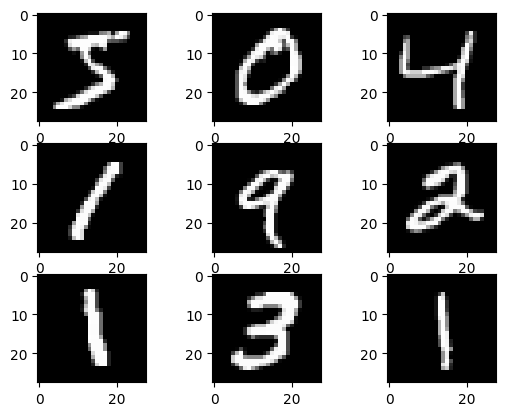

In [6]:
for i in range(9):  
    plt.subplot(331 + i)
    plt.imshow(train_images[i], cmap='gray')
plt.show()


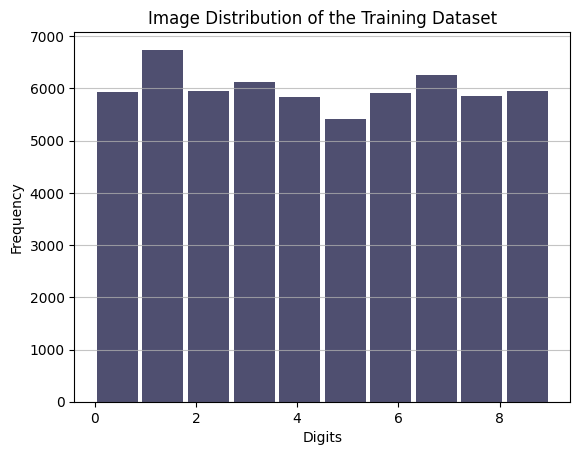

In [25]:
plt.hist(x=train_labels, bins=10, color="#050433", alpha=0.7, rwidth=0.9, align="mid"
    )
plt.grid(axis="y", alpha=0.75)
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("Image Distribution of the Training Dataset")
plt.show()

## Aufgabe 2 

In [26]:
def init_params():  # initializes the weights and biases for a two-layer (one hidden and one output layer) neural network.
    W1 = np.random.randn(
        10, 784
    )  # weight matrix for the first layer (hidden layer); the values are initialized from a normal dist
    b1 = np.random.randn(10, 1)  # bias for the hidden layer
    W2 = np.random.randn(10, 10)  # weights for the output layer
    b2 = np.random.randn(10, 1)  # bias for the output layer
    return W1, b1, W2, b2


# W1 is the weight matrix connecting the input layer to the hidden layer.
# Its shape is (10, 784), assuming the input vector X has 784 features (e.g., a 28x28 pixel image flattened out).
# W2 and b2 are the weight matrix and bias vector for the output layer, respectively.
# The output layer also consists of 10 neurons, suggesting that this network aims to classify inputs into one of 10 classes


def ReLU(
    Z,
):  # Rectified Linear Unit (ReLU) activation function. This introduces nonlinearity.
    return np.maximum(Z, 0)


# This function operates element-wise on the input value Z,
# returning 0 for any negative value in Z and the original value for any other


def softmax(Z):  # converts the output layers logits(Z) into probabilities
    Z -= np.max(
        Z, axis=0
    )  # Subtract max value for numerical stability to avoid overflow error
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)  # conversion of logits into probabilities
    return A


def forward_prop(
    W1, b1, W2, b2, X
):  # performs forward propagation through the network.
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return (
        Z1,
        A1,
        Z2,
        A2,
    )  # returns the pre-activation values Z and the activation values A


def one_hot(
    Y,
):  # coverts the labels vector into one-hot encoded matrix. transform int class labels into suitable format
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


def deriv_ReLU(
    Z,
):  # calculatse the derivative of the ReLU function, which is used during back propagation to calc gradient
    return Z > 0  # returns 1 for any positive input


def back_prop(
    Z1, A1, Z2, A2, W1, W2, X, Y
):  # performs back propagation, calc gradient of the loss function
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2


# m is the numbers of examples in X


def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1  # alpha is the learning rate
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2


# updates the parameters of the network (weights and bias using the gradients from back prop)


def get_predictions(A2):  # takes the output of the NN, A2 and returns predictions
    return np.argmax(A2, 0)


# It uses np.argmax to find the indices of the maximum values along axis 0
# (which corresponds to the most likely class for each example in the batch). These indices represent the predicted classes


def get_accuracy(
    predictions, Y
):  # compare predicted to actual class Y to compute accuracy of model
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


def gradient_descent(
    X, Y, iterations, alpha
):  # model params updated itiratively to minimize the loss function
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if (
            i % 50 == 0
        ):  # Every 50 iterations, it prints the current iteration number and the model's accuracy on the training set.
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

    # Initializes the weights and biases using init_params.
    # For a specified number of iterations, it:
    # Performs forward propagation to compute the current predictions given the training data X.
    # Computes the gradient of the loss with respect to the parameters using back_prop.
    # Updates the parameters (weights and biases) in the direction that reduces the loss,
    # using the update_params function and a specified learning rate alpha.

    # allow to learn frothe training data iteratively

